In [52]:
import warnings
warnings.filterwarnings('ignore')

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactiveity = 'all'

import numpy as np
import pandas as pd
import torch
import yfinance as yf
import hmmlearn.hmm as hmm
from matplotlib import cm, pyplot as plt
from matplotlib.dates import YearLocator, MonthLocator
import seaborn; seaborn.set()

In [2]:
russell = yf.download("^RUA")
russell

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1987-09-10,178.960007,178.960007,177.050003,178.830002,178.830002,0
1987-09-11,178.830002,181.470001,178.830002,181.339996,181.339996,0
1987-09-14,181.339996,182.250000,180.750000,181.789993,181.789993,0
1987-09-15,181.789993,181.789993,179.259995,179.270004,179.270004,0
1987-09-16,179.270004,180.630005,177.860001,177.889999,177.889999,0
...,...,...,...,...,...,...
2022-01-14,2712.169922,2715.120117,2683.719971,2714.169922,2714.169922,0
2022-01-18,2713.169922,2713.169922,2656.399902,2660.810059,2660.810059,0
2022-01-19,2661.010010,2680.550049,2632.719971,2633.860107,2633.860107,0


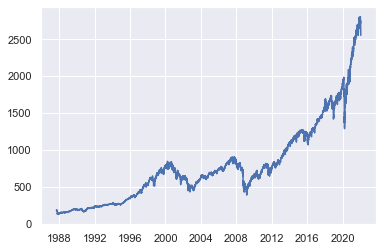

In [3]:
plt.plot(russell['Adj Close'])

In [4]:
russell['ret'] = russell['Adj Close'] / russell['Adj Close'].shift(1) - 1
df = russell[['Adj Close', 'ret']].dropna()
df

,Adj Close,ret
Date,,
1987-09-11,181.339996,0.014036
1987-09-14,181.789993,0.002482
1987-09-15,179.270004,-0.013862
1987-09-16,177.889999,-0.007698
1987-09-17,177.839996,-0.000281
...,...,...
2022-01-14,2714.169922,0.000464
2022-01-18,2660.810059,-0.019660
2022-01-19,2633.860107,-0.010128


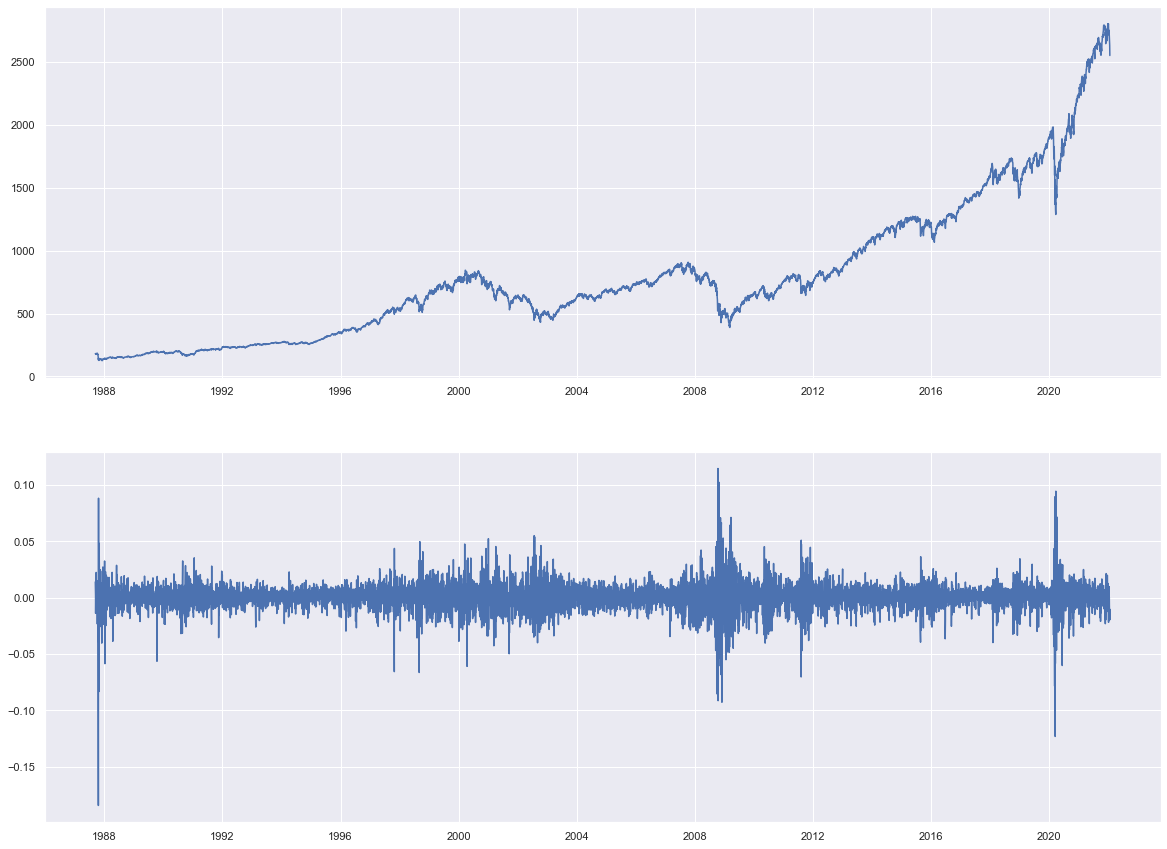

In [5]:
fig, axes = plt.subplots(2, 1, figsize=(20, 15))

for i, ax in enumerate(axes):
    ax.plot(df[df.columns[i]])

# 检测hmm效果

In [6]:
dates = np.array(df.index)
X = np.array(df['ret']).reshape(-1, 1)
X

array([[ 0.01403565],
       [ 0.00248151],
       [-0.01386209],
       ...,
       [-0.01012848],
       [-0.01169388],
       [-0.01940793]])

In [7]:
model = hmm.GaussianHMM(n_components=3, covariance_type='diag', n_iter=1000).fit(X)
hidden_states = model.predict(X)

print(model.transmat_)
print(model.predict_proba)

print('Means and vars of each hidden state :')
params = pd.DataFrame(columns = ('State', 'Means', 'Variance'))
for i in range(model.n_components):
    params.loc[i] = [format(i), model.means_[i], np.diag(model.covars_[i])]
    
params

[[9.80725694e-01 2.98870136e-06 1.92713170e-02]
 [8.59475062e-09 9.55832309e-01 4.41676825e-02]
 [3.06269255e-02 7.09797774e-03 9.62275097e-01]]
<bound method _BaseHMM.predict_proba of GaussianHMM(n_components=3, n_iter=1000)>
Means and vars of each hidden state :


,State,Means,Variance
0,0,[0.0009425625654903244],[3.7462476460367086e-05]
1,1,[-0.0021450782441343502],[0.0010281976036353247]
2,2,[-0.00011930136656155246],[0.0001538469748437426]


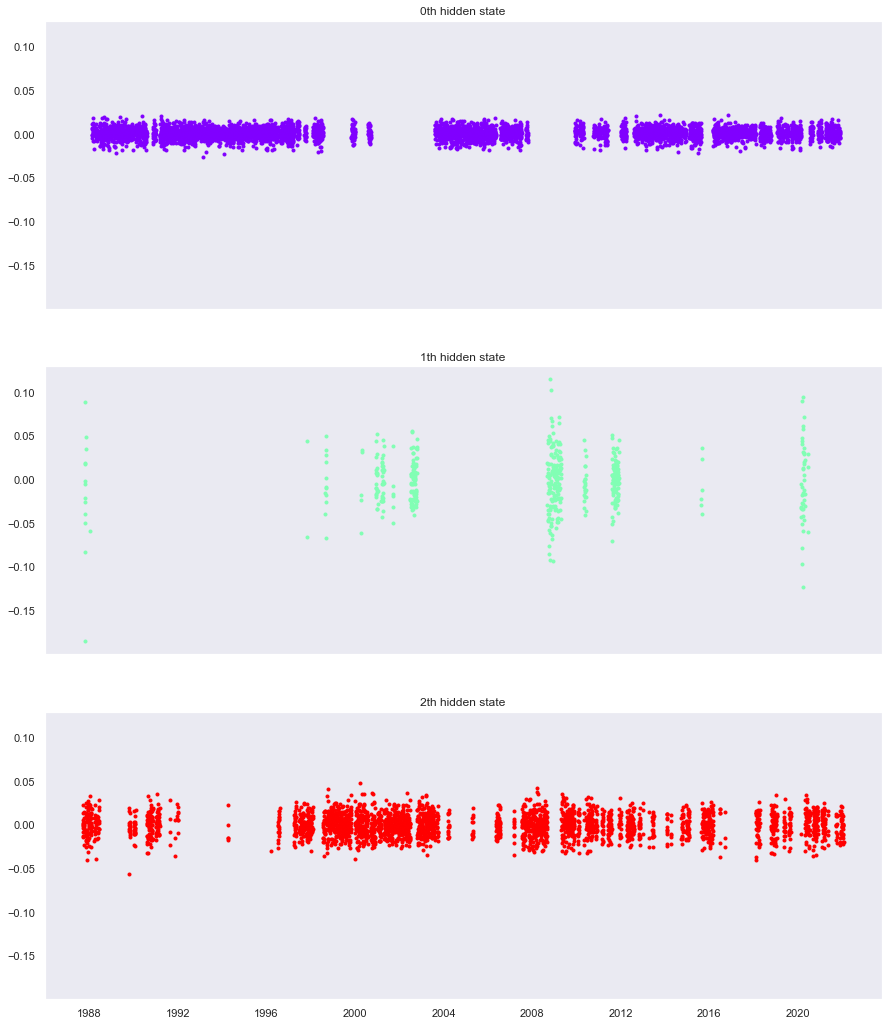

In [8]:
fig, axs = plt.subplots(model.n_components, sharex=True, sharey=True, figsize=(15,18))
colours = cm.rainbow(np.linspace(0, 1, model.n_components))

for i, (ax, color) in enumerate(zip(axs, colours)):
    mask = hidden_states == i
    ax.plot_date(dates[mask], X.reshape(-1)[mask], '.', c=color)
    ax.set_title('{}th hidden state'.format(i))
    
#     ax.xaxis.set_major_locator(YearLocator())
#     ax.xaxis.set_minor_locator(MonthLocator())
    
    ax.grid()
plt.show()

In [9]:
df['state'] = hidden_states
df

,Adj Close,ret,state
Date,,,
1987-09-11,181.339996,0.014036,2
1987-09-14,181.789993,0.002482,2
1987-09-15,179.270004,-0.013862,2
1987-09-16,177.889999,-0.007698,2
1987-09-17,177.839996,-0.000281,2
...,...,...,...
2022-01-14,2714.169922,0.000464,2
2022-01-18,2660.810059,-0.019660,2
2022-01-19,2633.860107,-0.010128,2


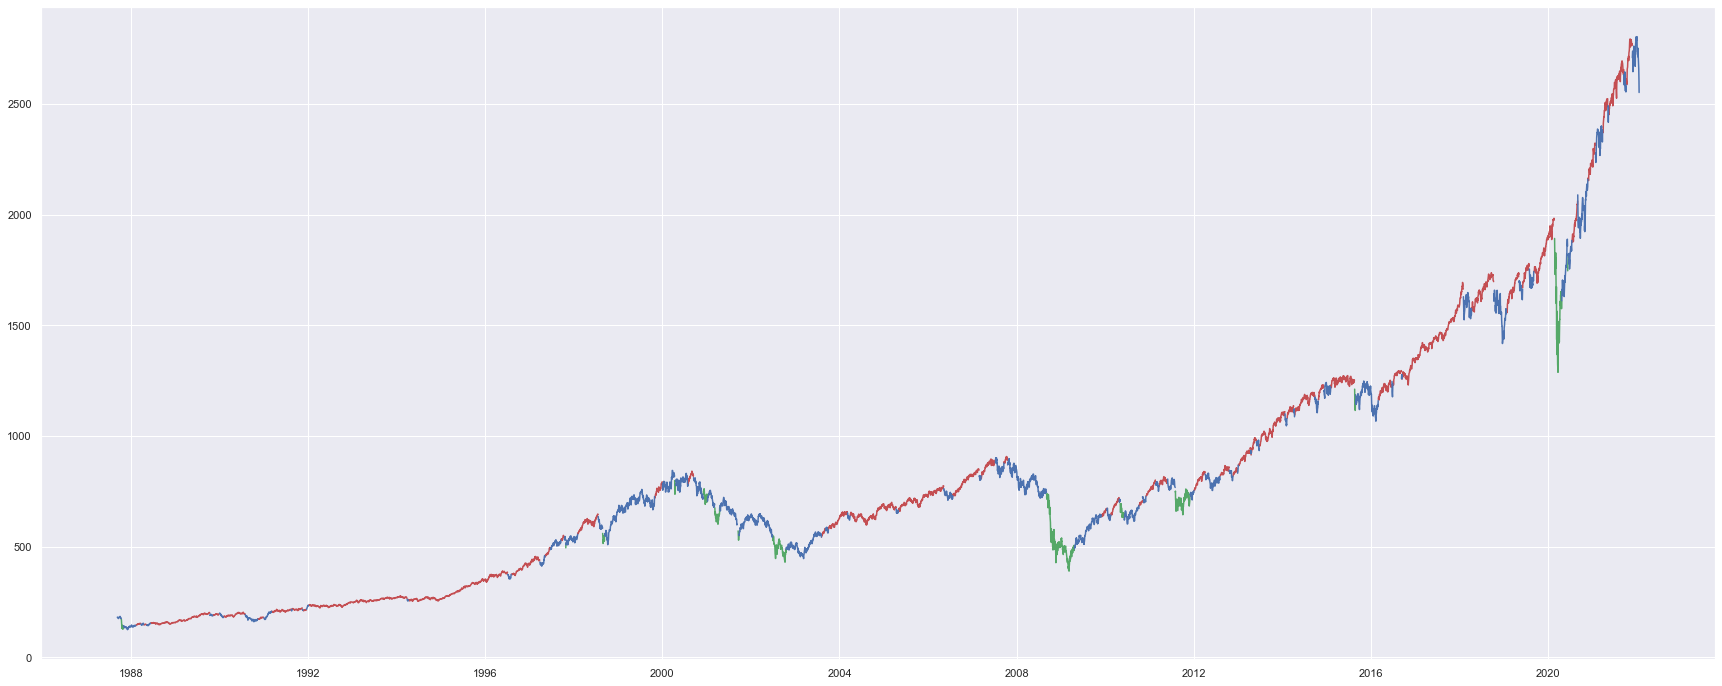

In [10]:
ret0 = df[df['state'] == 0]['Adj Close']
ret0 = ret0.reindex(df.index)
ret1 = df[df['state'] == 1]['Adj Close']
ret1 = ret1.reindex(df.index)
ret2 = df[df['state'] == 2]['Adj Close']
ret2 = ret2.reindex(df.index)
plt.figure(figsize=(30, 12))
plt.plot(ret0, color='r')
plt.plot(ret1, color='g')
plt.plot(ret2, color='b')
plt.show()

# 分集合训练和预测

In [36]:
train = df[df.index < '2018-01-01']
test = df[df.index >= '2018-01-01']

In [41]:
X_train = np.array(train['ret']).reshape(-1, 1)
X_test = np.array(test['ret']).reshape(-1, 1)
model = hmm.GaussianHMM(n_components=3, covariance_type='diag', n_iter=1000).fit(X_train)
hidden_states = model.predict(X_train)

print(model.transmat_)
print(model.predict_proba)

print('Means and vars of each hidden state :')
params = pd.DataFrame(columns = ('State', 'Means', 'Variance'))
for i in range(model.n_components):
    params.loc[i] = [format(i), model.means_[i], np.diag(model.covars_[i])]
    
params

[[9.83587641e-01 5.82585026e-08 1.64123005e-02]
 [9.00424095e-09 9.65660430e-01 3.43395612e-02]
 [2.68349055e-02 6.99413200e-03 9.66170962e-01]]
<bound method _BaseHMM.predict_proba of GaussianHMM(n_components=3, n_iter=1000)>
Means and vars of each hidden state :


,State,Means,Variance
0,0,[0.0008567010657175885],[3.802087780944876e-05]
1,1,[-0.0016143166261929293],[0.0008203646007039703]
2,2,[-6.742020356337133e-05],[0.0001425913517117772]


In [42]:
X_test

array([[ 8.27661342e-03],
       [ 5.84004105e-03],
       [ 3.63201760e-03],
       [ 6.42448602e-03],
       [ 1.83793981e-03],
       [ 9.66582561e-04],
       [-1.20552238e-03],
       [ 8.26377760e-03],
       [ 6.10120449e-03],
       [-4.55878751e-03],
       [ 9.22640044e-03],
       [-2.08457525e-03],
       [ 5.53423740e-03],
       [ 7.82811835e-03],
       [ 2.41379288e-03],
       [-1.31127435e-03],
       [ 4.83394119e-04],
       [ 1.06781033e-02],
       [-6.78183621e-03],
       [-1.06908912e-02],
       [-4.20160919e-05],
       [-1.86257169e-04],
       [-2.09147825e-02],
       [-3.98267152e-02],
       [ 1.60546026e-02],
       [-4.15150239e-03],
       [-3.65846221e-02],
       [ 1.39583015e-02],
       [ 1.33264264e-02],
       [ 2.78209325e-03],
       [ 1.40946499e-02],
       [ 1.18343100e-02],
       [ 6.32558472e-04],
       [-5.93106385e-03],
       [-4.76940143e-03],
       [ 4.88639140e-04],
       [ 1.54216085e-02],
       [ 1.07477486e-02],
       [-1.2

In [53]:
pred_hidden_states=model.decode(X_test, algorithm='viterbi')[1]
test['pred_states'] = pd.Series(pred_hidden_states, index=test.index)
test

,Adj Close,ret,state,pred_states
Date,,,,
2018-01-02,1595.869995,0.008277,0,2
2018-01-03,1605.189941,0.005840,0,0
2018-01-04,1611.020020,0.003632,0,0
2018-01-05,1621.369995,0.006424,0,0
2018-01-08,1624.349976,0.001838,0,0
...,...,...,...,...
2022-01-14,2714.169922,0.000464,2,2
2022-01-18,2660.810059,-0.019660,2,2
2022-01-19,2633.860107,-0.010128,2,2


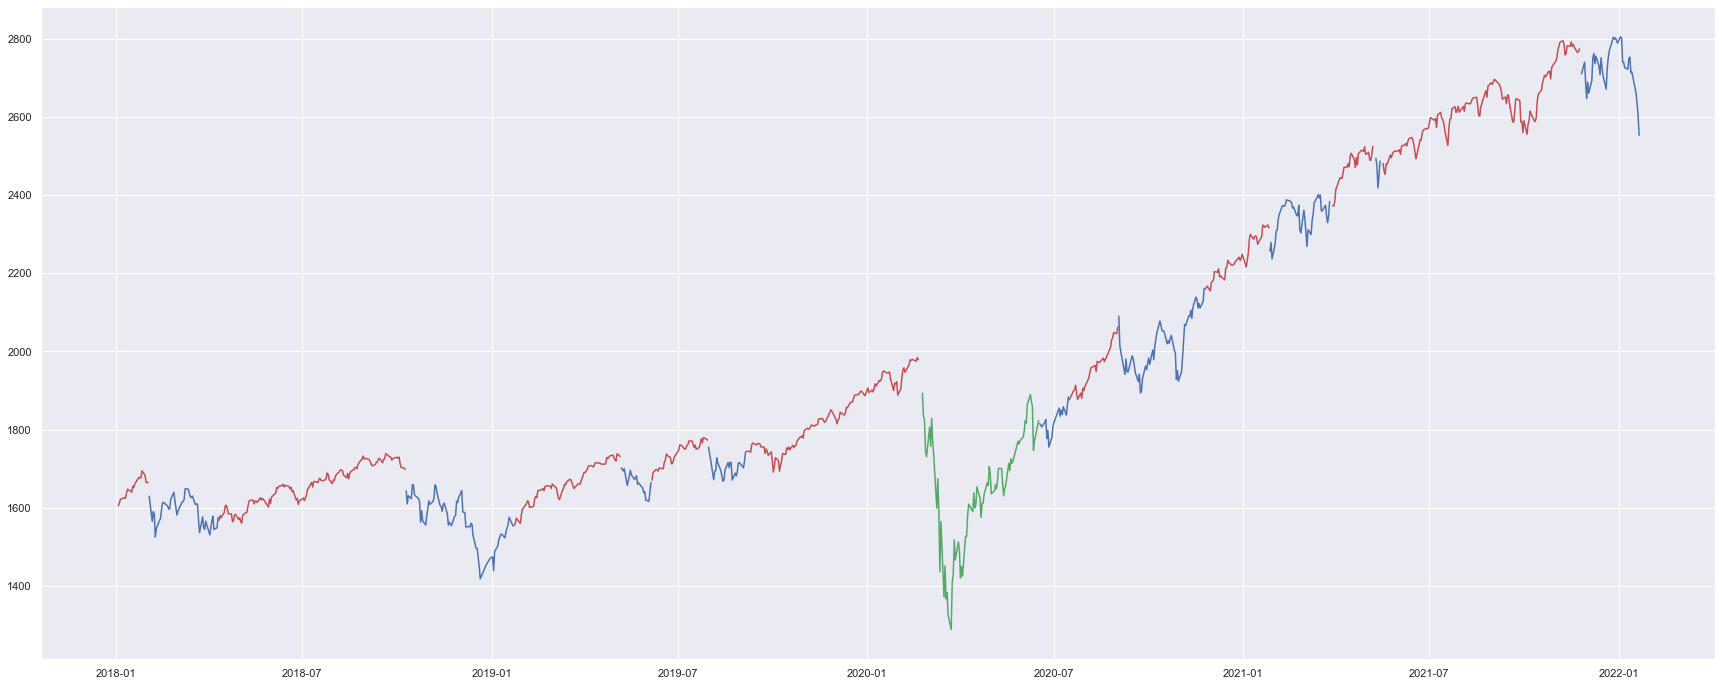

In [59]:
test['pred_states'].shift(1)
ret0 = test[test['pred_states'] == 0]['Adj Close']
ret0 = ret0.reindex(df.index)
ret1 = test[test['pred_states'] == 1]['Adj Close']
ret1 = ret1.reindex(df.index)
ret2 = test[test['pred_states'] == 2]['Adj Close']
ret2 = ret2.reindex(df.index)
plt.figure(figsize=(30, 12))
plt.plot(ret0, color='r')
plt.plot(ret1, color='g')
plt.plot(ret2, color='b')
plt.show()